In [1]:

# LangGraph官方文档教程：
# https://langchain-ai.github.io/langgraph/tutorials/get-started/4-human-in-the-loop/



In [2]:
# Add human-in-the-loop controls¶
# 添加人机交互控制 ¶
# Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.
# 代理可能不可靠，可能需要人工输入才能成功完成任务。同样，对于某些操作，您可能需要在运行前获得人工批准，以确保一切按预期运行。

# LangGraph's persistence layer supports human-in-the-loop workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the interrupt function. Calling interrupt inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a Command. interrupt is ergonomically similar to Python's built-in input(), with some caveats.
# LangGraph 的持久层支持人机交互工作流，允许根据用户反馈暂停和恢复执行。此功能的主要接口是 interrupt 函数。在节点内部调用 interrupt 将暂停执行。可以通过传入 Command 来 interrupt 执行，并接收新的人工输入。interrupt 在人机工程学上类似于 Python 的内置 input() ， 但也有一些注意事项 。


In [3]:
# Note  笔记

# This tutorial builds on Add memory.
# 本教程以 “添加内存” 为基础。

In [4]:
# 1. Add the human_assistance tool¶
# 1. 添加 human_assistance 工具 ¶
# Starting with the existing code from the Add memory to the chatbot tutorial, add the human_assistance tool to the chatbot. This tool uses interrupt to receive information from a human.
# 从 “为聊天机器人添加内存”教程中的现有代码开始，将 human_assistance 工具添加到聊天机器人。此工具使用 interrupt 来接收来自人类的信息。

# Let's first select a chat model:
# 我们先选择一个聊天模型：


In [5]:
# pip install -U "langchain[google-genai]"

In [6]:
import getpass
import os
from langchain.chat_models import init_chat_model

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [7]:
# We can now incorporate it into our StateGraph with an additional tool:
# 我们现在可以使用附加工具将其合并到我们的 StateGraph 中：


In [8]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [9]:
# Tip  提示

# For more information and examples of human-in-the-loop workflows, see Human-in-the-loop.
# 有关人机交互工作流程的更多信息和示例，请参阅人机交互 。

# https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/



In [10]:
# 2. Compile the graph¶
# 2. 编译图表 ¶
# We compile the graph with a checkpointer, as before:
# 我们使用检查点来编译图表，就像之前一样：


In [11]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [12]:
# 3. Visualize the graph (optional)¶
# 3. 可视化图表（可选） ¶
# Visualizing the graph, you get the same layout as before – just with the added tool!
# 通过可视化图表，您可以获得与以前相同的布局 - 只需添加工具！


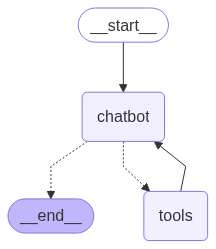

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
# 4. Prompt the chatbot¶
# 4. 提示聊天机器人 ¶
# Now, prompt the chatbot with a question that will engage the new human_assistance tool:
# 现在，向聊天机器人提出一个问题，该问题将使用新的 human_assistance 工具：


In [15]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (3fcd4842-0637-479f-9a7a-38c25e47f72a)
 Call ID: 3fcd4842-0637-479f-9a7a-38c25e47f72a
  Args:
    query: I need expert guidance on building an AI agent.


In [16]:
# The chatbot generated a tool call, but then execution has been interrupted. If you inspect the graph state, you see that it stopped at the tools node:
# 聊天机器人生成了一个工具调用，但随后执行被中断。如果您检查图形状态，您会发现它在工具节点处停止了：


In [17]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [18]:
# Info  信息

# Take a closer look at the human_assistance tool:
# 仔细看看 human_assistance 工具：


# @tool
# def human_assistance(query: str) -> str:
#     """Request assistance from a human."""
#     human_response = interrupt({"query": query})
#     return human_response["data"]
# Similar to Python's built-in input() function, calling interrupt inside the tool will pause execution. Progress is persisted based on the checkpointer; so if it is persisting with Postgres, it can resume at any time as long as the database is alive. In this example, it is persisting with the in-memory checkpointer and can resume any time if the Python kernel is running.
# 与 Python 内置的 input() 函数类似，在工具内部调用 interrupt 会暂停执行。进度会根据检查点进行持久化；因此，如果使用 Postgres 进行持久化，只要数据库还处于活动状态，就可以随时恢复。在本例中，它使用内存中的检查点进行持久化，只要 Python 内核正在运行，就可以随时恢复。



In [19]:
# 5. Resume execution¶
# 5. 恢复执行 ¶
# To resume execution, pass a Command object containing data expected by the tool. The format of this data can be customized based on needs. For this example, use a dict with a key "data":
# 要恢复执行，请传递一个包含工具所需数据的 Command 对象。此数据的格式可以根据需求自定义。在本例中，使用一个带有键 "data" 字典：


In [20]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (3fcd4842-0637-479f-9a7a-38c25e47f72a)
 Call ID: 3fcd4842-0637-479f-9a7a-38c25e47f72a
  Args:
    query: I need expert guidance on building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent, as it is more reliable and extensible than simple autonomous agents.


In [21]:
# The input has been received and processed as a tool message. Review this call's LangSmith trace to see the exact work that was done in the above call. Notice that the state is loaded in the first step so that our chatbot can continue where it left off.
# 输入已接收并处理为工具消息。查看此调用的 LangSmith 跟踪 ，了解上述调用中完成的具体工作。请注意，状态已在第一步加载，以便我们的聊天机器人可以从中断处继续执行。

# Congratulations! You've used an interrupt to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since you have already added a checkpointer, as long as the underlying persistence layer is running, the graph can be paused indefinitely and resumed at any time as if nothing had happened.
# 恭喜！ 您已使用 interrupt 为聊天机器人添加了人机交互执行功能，以便在需要时进行人工监督和干预。这开启了您使用 AI 系统创建潜在 UI 的大门。由于您已添加检查点 ，只要底层持久层正在运行，图表就可以无限期暂停并随时恢复，就像什么都没发生过一样。
